In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import sys
import os
from pathlib import Path
from importlib import reload

sys.path.append('../')
import waveform_processing as proc
reload(proc)

<module 'waveform_processing' from '../waveform_processing.py'>

In [2]:
plt.style.use('dark_background')
#matplotlib.rcParams.keys()
plt.rcParams['figure.figsize'] = (10, 6)
plt.rc('font', size=12)
length = 8
width = 1.5
plt.rcParams['xtick.major.size'] = length
plt.rcParams['ytick.major.size'] = length
plt.rcParams['xtick.major.width'] = width
plt.rcParams['ytick.major.width'] = width

In [3]:
expname='xcsx35017'
dirname=Path('/reg/d/psdm/%s/%s/hdf5/smalldata/'%(expname[0:3],expname))

def fileName_forTraces(expname, run):
    return'%s_Run%03d.h5'%(expname, run)

In [4]:
run = 112 # single pulse traces
fname = dirname / fileName_forTraces(expname, run)
with h5.File(fname, 'r') as f:
    print(f.keys())
#     d_icarus = np.asarray(f['icarus_pink']['full'])
    dat_1pulse = -np.asarray(f['acq01']['full'])[:500]


runs = np.arange(70,90) # 4 pulse traces
dat = []
for run in runs:
    fname = dirname / fileName_forTraces(expname, run)
    with h5.File(fname, 'r') as f:
#         print(f.keys())
    #     d_icarus = np.asarray(f['icarus_pink']['full'])
        d_acq = np.asarray(f['acq01']['full'])
        print(d_acq.shape)
        dat.append(-d_acq)
dat = np.concatenate(dat)
print(dat.shape)

<KeysViewHDF5 ['UserDataCfg', 'acq01', 'damage', 'ebeam', 'epics', 'event_time', 'evr', 'feeBld', 'fiducials', 'gas_detector', 'icarus_pink', 'icarus_yellow', 'ipm4', 'ipm5', 'jungfrau512k', 'lightStatus', 'scan', 'snd_dio']>
(10, 4000)
(4, 4000)
(5, 4000)
(3, 4000)
(1, 4000)
(1, 4000)
(1, 4000)
(4, 4000)
(2, 4000)
(1, 4000)
(1, 4000)
(1, 4000)
(1, 4000)
(1, 4000)
(1, 4000)
(1, 4000)
(1, 4000)
(1, 4000)
(1, 4000)
(1, 4000)
(42, 4000)


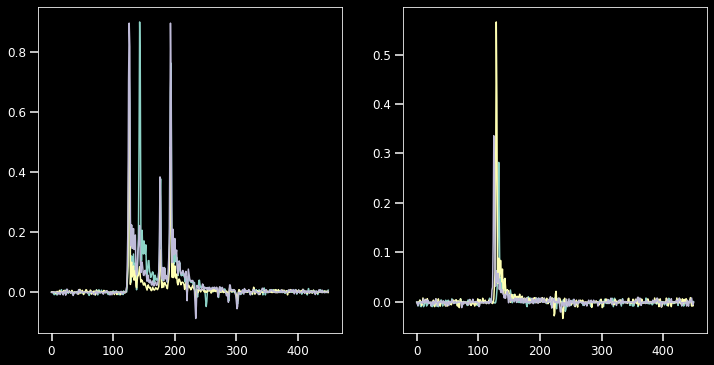

In [5]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].plot(dat[14:17,1350:1800].T)
ax[1].plot(dat_1pulse[10:13,1350:1800].T)
# plt.xlim(50,150)
plt.show()

In [6]:
dat = dat[:,1350:1800]
dat_1pulse = dat_1pulse[:,1350:1800]

In [7]:
# plt.plot(dat[1])
# plt.xlim(115,135)

Data need to be aligned before building the basis.

# (i) Align pulses

Test between correlation and convolution.

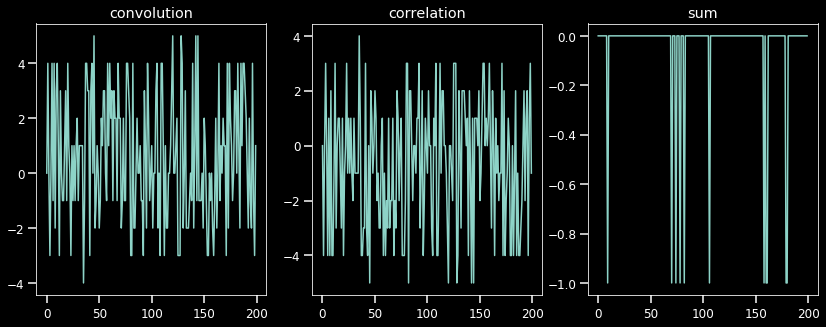

In [8]:
conv = []
corr = []

for wave in dat_1pulse[:200]:
    conv.append( np.argmax(np.convolve(dat_1pulse[0], wave, 'full')) )
    corr.append( np.argmax(np.correlate(dat_1pulse[0], wave, 'full')) )

conv = conv-np.median(conv)
corr = corr-np.median(corr)
fig, ax = plt.subplots(1,3, figsize=(14,5))
ax[0].plot(conv)
ax[0].set_title('convolution')
ax[1].plot(corr)
ax[1].set_title('correlation')
ax[2].plot(corr+conv)
ax[2].set_title('sum')
plt.show()

Convolution and correlation are consistent in calculating the shift. There is just a sign difference, as expected.

In [9]:
# single pulse
ref = np.argmax(np.convolve(dat_1pulse[0],dat_1pulse[0]))
for ii, wave in enumerate(dat_1pulse):
    shift = np.argmax(np.convolve(dat_1pulse[0], wave, 'full')) - ref
    dat_1pulse[ii] = np.roll(wave, -shift)
    
# 4 pulse
conv_range = (120,135)
ref = np.argmax(np.convolve(dat[1,conv_range[0]:conv_range[1]],dat[1,conv_range[0]:conv_range[1]]))
for ii, wave in enumerate(dat):
    shift = np.argmax(np.convolve(dat[1,conv_range[0]:conv_range[1]], wave[conv_range[0]:conv_range[1]], 'full')) - ref
    dat[ii] = np.roll(wave, -shift)

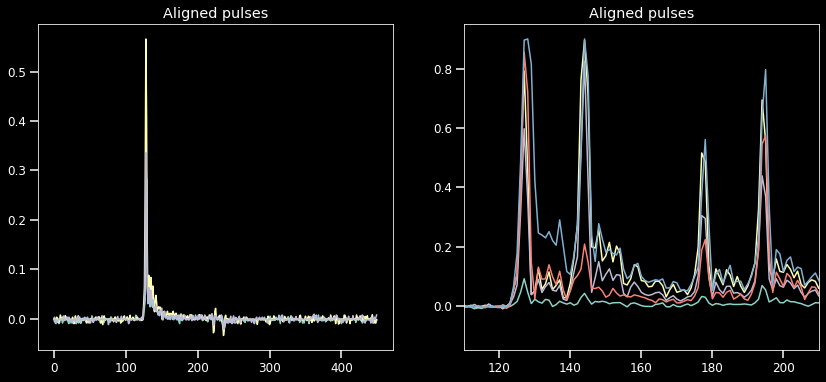

In [10]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[0].plot(dat_1pulse[10:13,:].T)
ax[0].set_title('Aligned pulses')

# ax[1].plot(dat[35:39,:].T)
ax[1].plot(dat[20:25,:].T)
ax[1].set_title('Aligned pulses')
ax[1].set_xlim(110,210)
plt.show()

# (ii) Get single pulse basis

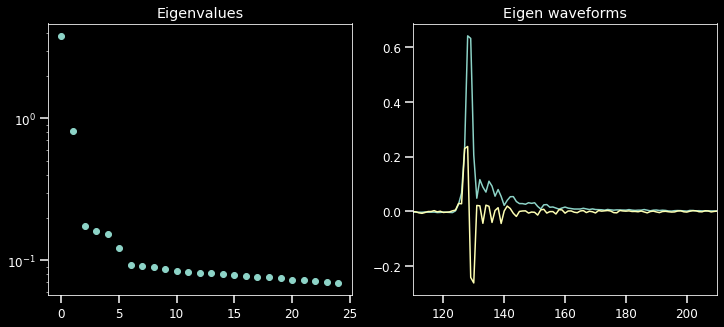

In [11]:
n_c = 2
A, proj, svd = proc.get_basis_and_projector(dat_1pulse[:50], n_components=n_c)

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].set_title('Eigenvalues')
ax[0].plot(svd.singular_values_,'o')
ax[0].set_yscale('log')
ax[1].set_title('Eigen waveforms')
ax[1].plot(svd.components_[0])
ax[1].plot(0.5*svd.components_[1])
ax[1].set_xlim(110,210)
plt.show()

The second components still is important here. As seen later, there is some jitter in the data, which can be accounted by the second component (~1st derivative).

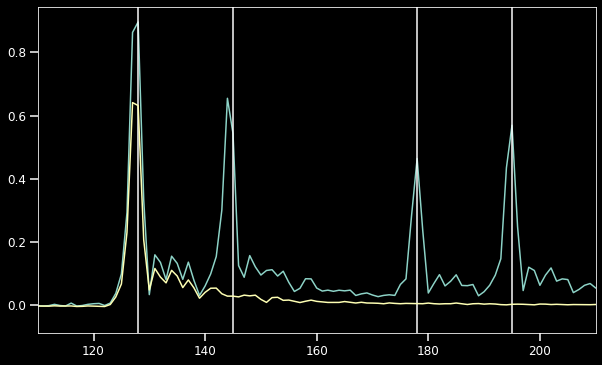

In [12]:
# conv = np.convolve(A.squeeze(), dat[1], 'full')
p1 = np.argmax(dat[1])
p2 = p1+3 + np.argmax(dat[1,p1+3:])+1
p4 = p2+3 + np.argmax(dat[1,p2+3:])
p3 = p2+3 + np.argmax(dat[1,p2+3:p4])
plt.plot(dat[1])
plt.axvline(x=p1)
plt.axvline(x=p2)
plt.axvline(x=p3)
plt.axvline(x=p4)
plt.plot(np.roll(A[:,0],-1))
# plt.plot(0.5*np.roll(A[:,1],2))
plt.xlim(110,210)

plt.show()

## Build basis by shifting the single pulse basis accordingly

(120, 220)

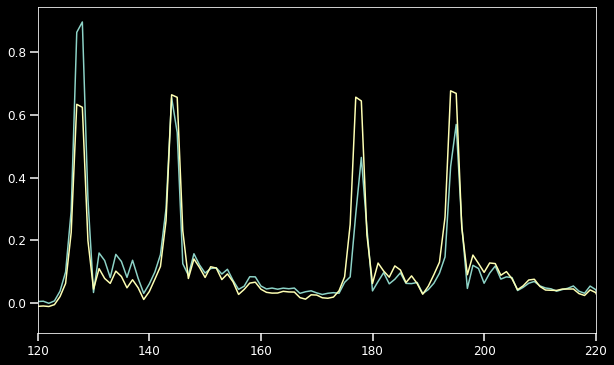

In [13]:
dl = [-1, p2-p1, p3-p1, p4-p1]
A0 = np.roll(A, dl[0], axis=0)
A1 = np.roll(A0, dl[1], axis=0)
A2 = np.roll(A0, dl[2], axis=0)
A3 = np.roll(A0, dl[3], axis=0)
A_tot = np.concatenate([A0,A1,A2,A3], axis=1)

plt.plot(dat[1])
plt.plot(np.sum(A_tot[:,0::n_c], axis=1))
plt.xlim(120,220)

# Test the 4-pulse fit

In [14]:
proj = np.linalg.pinv(A_tot)
regr = proc.WaveformRegressor(A=A_tot, projector=proj)

In [15]:
reconstructed = regr.fit_reconstruct(dat)

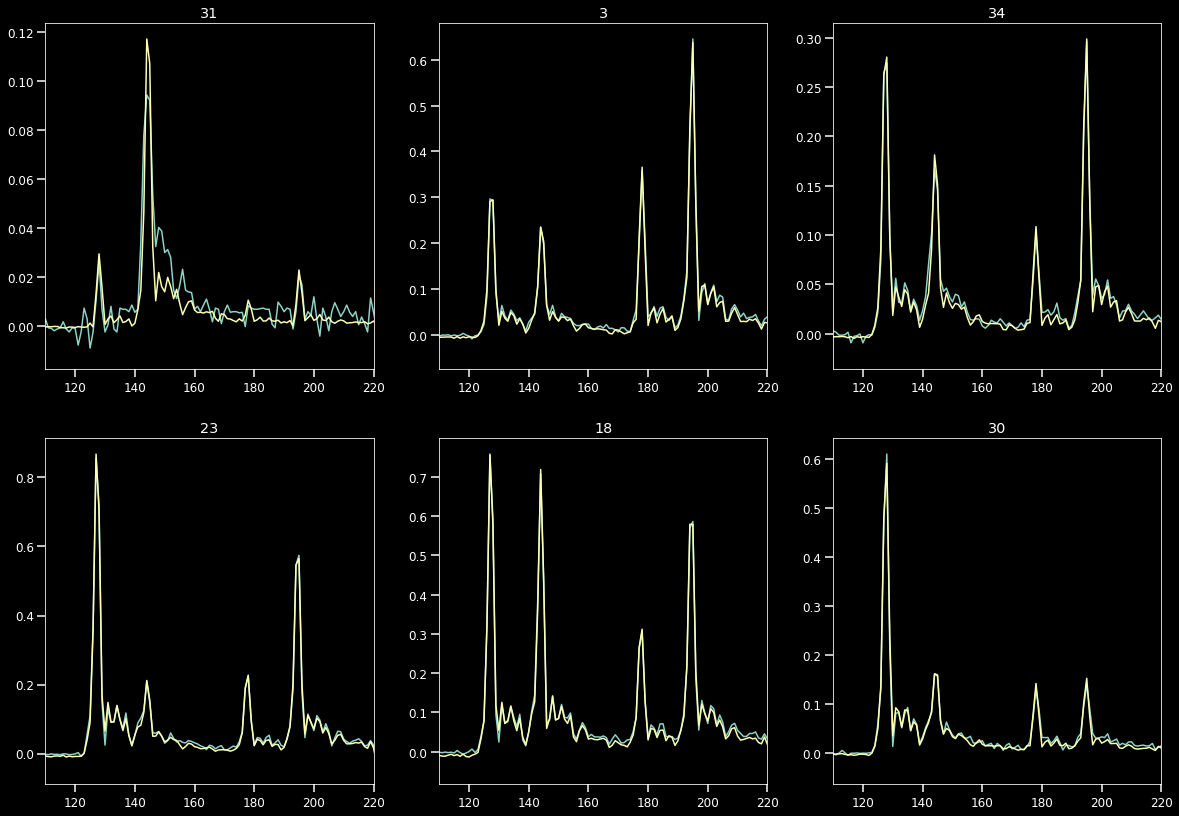

In [16]:
fig, ax = plt.subplots(2,3, figsize=(20,14))
ax = np.ravel(ax)
for ii in range(6):
    idx = np.random.randint(dat.shape[0])
    ax[ii].plot(dat[idx])
    ax[ii].plot(reconstructed[idx])
    ax[ii].set_xlim(110,220)
    ax[ii].set_title(str(idx))

There is a small jitter in the different peak position. Because the sampling is of the order of the feature time scale, a small shift can have a big impact. Interestingly, peaks seems to sometimes shift with respect to one-another as well; it is not a shift of the whole waveform. In order to accont for that, it is best to fit the data with two components (n_c=2), since the second component can be seen as the derivative of the curves and encodes information about small shifts.

By rerunning the analysis with only one component, the effects of those small shifts become evident.

The intensity of each pulse is given by the norm the corresponding coefficient in the basis: np.linalg.norm(coeff_pulse_ii)

# Test new code (multi-pulse)

Test implementation of the multi-pulse fit in the waveform_processing package. It should produce the same results as above.

In [68]:
reload(proc)
dl = [-1, p2-p1-1, p3-p1, p4-p1]
n_c = 3
regr2 = proc.construct_waveformRegressor(dat_1pulse[:50], n_components=n_c, n_pulse=4, delay=dl)

(110, 210)

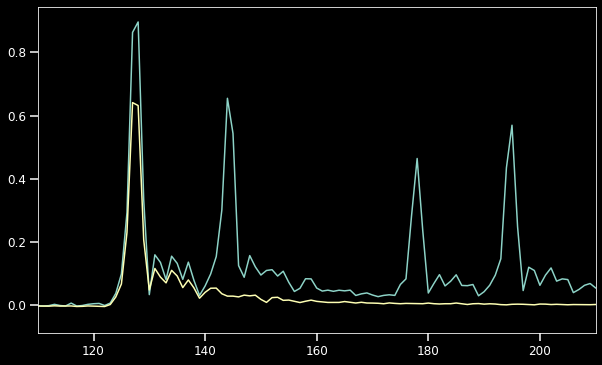

In [69]:
plt.plot(dat[1])
plt.axvline(x=dl[0])
plt.axvline(x=dl[1])
plt.axvline(x=dl[2])
plt.axvline(x=dl[3])
plt.plot(regr2.A[0])
plt.xlim(110,210)

(120, 220)

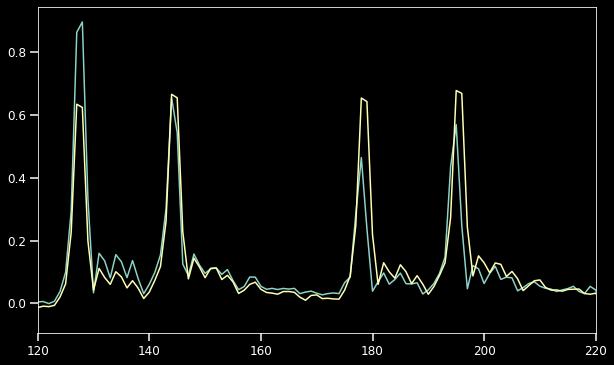

In [70]:
plt.plot(dat[1])
plt.plot(np.sum(regr2.A[0::n_c,:], axis=0))
plt.xlim(120,220)

In [71]:
reconstructed = regr2.fit_reconstruct(dat)
intensities = regr2.get_pulse_intensity(dat)
intensities_max = regr2.get_pulse_intensity(dat, mode='max')
score = regr2.score(dat)

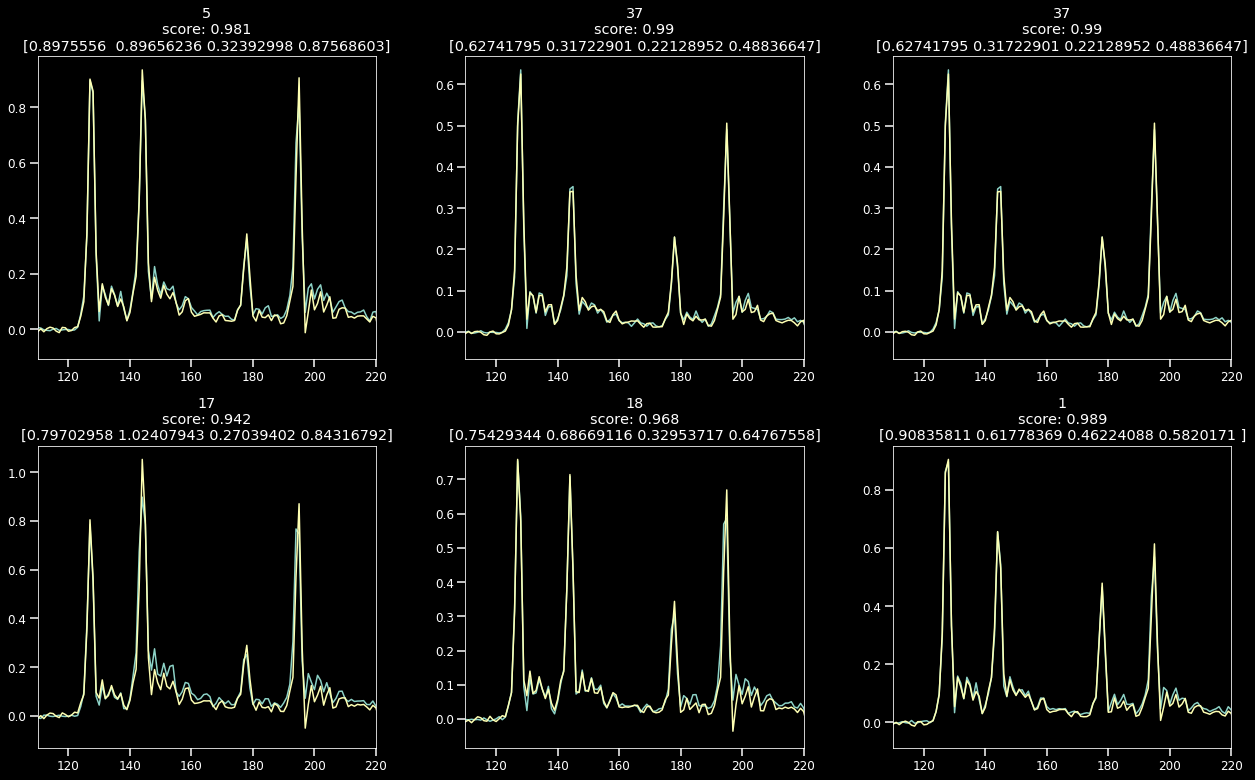

In [81]:
fig, ax = plt.subplots(2,3, figsize=(18,11))
ax = np.ravel(ax)
for ii in range(6):
    idx = np.random.randint(dat.shape[0])
    ax[ii].plot(dat[idx])
    ax[ii].plot(reconstructed[idx])
    ax[ii].set_xlim(110,220)
    ax[ii].set_title('{}\nscore: {:.3}\n'.format(str(idx), score[idx])+str(intensities_max[idx]))
plt.tight_layout()
plt.show()

### Intensity ratio: compare the two methods to calculate intensity

In [22]:
ii = 15
print(intensities[ii,0]/intensities[ii,1])
print(intensities_max[ii,0]/intensities_max[ii,1])
print('\n')

print(intensities[ii,1]/intensities[ii,2])
print(intensities_max[ii,1]/intensities_max[ii,2])
print('\n')

print(intensities[ii,2]/intensities[ii,3])
print(intensities_max[ii,2]/intensities_max[ii,3])

9.508056772101627
9.970030055185005


0.4501678309483027
0.4853212489085832


0.3076967623724719
0.2840837855348536


The ratios are close, but not the same. This is a problem. The norm of the coefficient might not be the right approach if the basis is not orthonormal. Let's check.

## Check orthonormality

In [23]:
A = regr2.A
print(A[0].dot(A[0]))
print(A[0].dot(A[n_c-1]))
print(A[0].dot(A[n_c]))

1.0000000000000002
-9.540979117872439e-17
0.0723764388196062


The basis is clearly not orthogonal. This explains why the norm of the coefficient should not be used to calculate the intensity for multi-pulse waveforms. It works well for single pulse waveforms though.

While an orthogonal basis can be constructed, it will not be straightforward to extract the pulse intensities from it. 

#### Recommendation: use mode='max' to calculate the intensities of multi-pulse waveforms.